# FIBO Graph Exploratory Data Analysis

This notebook provides a quick exploration of the Financial Industry Business Ontology (FIBO) graph structure and contents.


In [1]:
# Setup and load FIBO graph
from pathlib import Path
from rdflib import Graph, Namespace, RDFS, OWL, RDF
from rdflib.namespace import SKOS
import pandas as pd
from collections import Counter

# Load the graph
STORE_PATH = Path("./data/fibo.db")
print(f"Loading FIBO from {STORE_PATH}...")
g = Graph()
g.parse(STORE_PATH, format="turtle")
print(f"✅ Loaded {len(g):,} triples")


Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#dateTime, Converter=<built-in method fromisoformat of type object at 0x104e904e8>
Traceback (most recent call last):
  File "/Users/anthony/Repos/fibo-mcp/.venv/lib/python3.13/site-packages/rdflib/term.py", line 2262, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
ValueError: Invalid isoformat string: '2025-10-6T18:00:00'
Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#dateTime, Converter=<built-in method fromisoformat of type object at 0x104e904e8>
Traceback (most recent call last):
  File "/Users/anthony/Repos/fibo-mcp/.venv/lib/python3.13/site-packages/rdflib/term.py", line 2262, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
ValueError: Invalid isoformat string: '2025-10-6T18:00:00'


Loading FIBO from data/fibo.db...


Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#dateTime, Converter=<built-in method fromisoformat of type object at 0x104e904e8>
Traceback (most recent call last):
  File "/Users/anthony/Repos/fibo-mcp/.venv/lib/python3.13/site-packages/rdflib/term.py", line 2262, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
ValueError: Invalid isoformat string: '2025-6-24T18:00:00'
Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#dateTime, Converter=<built-in method fromisoformat of type object at 0x104e904e8>
Traceback (most recent call last):
  File "/Users/anthony/Repos/fibo-mcp/.venv/lib/python3.13/site-packages/rdflib/term.py", line 2262, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
ValueError: Invalid isoformat string: '2025-10-6T18:00:00'
Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#dateTime, Con

✅ Loaded 129,990 triples


## 1. Basic Graph Statistics


In [2]:
# Basic statistics
stats = {
    "Total Triples": len(g),
    "Unique Subjects": len(set(g.subjects())),
    "Unique Predicates": len(set(g.predicates())),
    "Unique Objects": len(set(g.objects())),
}

# Count different types of entities
class_count = len(list(g.subjects(RDF.type, OWL.Class)))
property_count = len(list(g.subjects(RDF.type, OWL.ObjectProperty))) + \
                 len(list(g.subjects(RDF.type, OWL.DatatypeProperty)))
individual_count = len(list(g.subjects(RDF.type, OWL.NamedIndividual)))

stats.update({
    "Classes": class_count,
    "Properties": property_count,
    "Individuals": individual_count
})

for key, value in stats.items():
    print(f"{key:20} {value:>10,}")


Total Triples           129,990
Unique Subjects          20,604
Unique Predicates           234
Unique Objects           51,258
Classes                   3,371
Properties                1,252
Individuals              11,729


## 2. Most Common Predicates


In [3]:
# Most common predicates
predicate_counts = Counter(p for s, p, o in g)
common_predicates = predicate_counts.most_common(15)

print("Top 15 Most Common Predicates:\n")
for pred, count in common_predicates:
    # Try to get a readable name
    if '#' in str(pred):
        name = str(pred).split('#')[-1]
    elif '/' in str(pred):
        name = str(pred).split('/')[-1]
    else:
        name = str(pred)
    print(f"{name:40} {count:>8,}")


Top 15 Most Common Predicates:

type                                       33,038
label                                      16,746
subClassOf                                  7,273
definition                                  5,891
imports                                     3,945
hasTag                                      3,634
identifies                                  3,462
isMemberOf                                  3,285
onProperty                                  3,170
isManagedBy                                 2,827
operatesInCountry                           2,798
hasFormalName                               2,798
operatesInMunicipality                      2,798
hasMarketIdentifierCodeStatus               2,796
hasWebsite                                  2,702


## 3. Namespace Distribution


In [4]:
# Analyze namespace distribution
from urllib.parse import urlparse

def get_namespace(uri):
    """Extract namespace from URI"""
    if not uri.startswith('http'):
        return 'other'
    parsed = urlparse(str(uri))
    if 'edmcouncil.org/fibo' in parsed.netloc + parsed.path:
        # Get FIBO module (BE, FND, SEC, etc.)
        parts = parsed.path.split('/')
        for i, part in enumerate(parts):
            if part == 'ontology' and i+1 < len(parts):
                return f"FIBO/{parts[i+1]}"
    elif 'w3.org' in parsed.netloc:
        return 'W3C'
    elif 'omg.org' in parsed.netloc:
        return 'OMG'
    else:
        return parsed.netloc

# Count subjects by namespace
namespace_counts = Counter()
for s in g.subjects():
    ns = get_namespace(s)
    namespace_counts[ns] += 1

print("Subject Distribution by Namespace:\n")
for ns, count in namespace_counts.most_common(10):
    print(f"{ns:30} {count:>8,}")


Subject Distribution by Namespace:

FIBO/FBC                         70,133
other                            12,642
FIBO/FND                         11,711
FIBO/SEC                          9,743
FIBO/BE                           8,290
FIBO/IND                          5,658
FIBO/DER                          3,849
FIBO/LOAN                         2,274
FIBO/BP                           1,885
FIBO/CAE                          1,071


## 4. Label and Definition Coverage


In [5]:
# Check label and definition coverage for classes
classes_with_labels = 0
classes_with_definitions = 0
total_classes = 0

for cls in g.subjects(RDF.type, OWL.Class):
    total_classes += 1
    if g.value(cls, RDFS.label):
        classes_with_labels += 1
    if g.value(cls, SKOS.definition):
        classes_with_definitions += 1

print("Class Documentation Coverage:\n")
print(f"Total Classes:        {total_classes:>8,}")
print(f"With Labels:          {classes_with_labels:>8,} ({100*classes_with_labels/total_classes:.1f}%)")
print(f"With Definitions:     {classes_with_definitions:>8,} ({100*classes_with_definitions/total_classes:.1f}%)")
print(f"Missing Definitions:  {total_classes - classes_with_definitions:>8,} ({100*(total_classes - classes_with_definitions)/total_classes:.1f}%)")


Class Documentation Coverage:

Total Classes:           3,371
With Labels:             2,950 (87.5%)
With Definitions:        2,664 (79.0%)
Missing Definitions:       707 (21.0%)


## 5. Sample Search Queries


In [6]:
# Search for concepts containing "country" (shows FIBO uses different terminology)
query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?concept ?label ?definition WHERE {
    ?concept rdfs:label ?label .
    OPTIONAL { ?concept skos:definition ?definition }
    FILTER(CONTAINS(LCASE(?label), "country"))
} LIMIT 5
"""

results = list(g.query(query))  # Convert to list to reuse
print("Searching for 'country' in labels:")
print("-" * 50)

if len(results) == 0:
    print("❌ No results for 'country' - FIBO uses 'sovereign state' or 'jurisdiction' instead")
else:
    for row in results:
        print(f"Label: {row.label}")
        if row.definition:
            print(f"Definition: {str(row.definition)[:100]}...")
        print()


Searching for 'country' in labels:
--------------------------------------------------
Label: authorized country
Definition: Country in which it is authorised to commercialise the fund....

Label: processing country
Definition: Country in which the processing characteristic applies....

Label: has home country
Definition: indicates, with respect to a foreign bank, the country in which the foreign bank is chartered or inc...

Label: has home country supervisor
Definition: indicates, with respect to a foreign bank, the governmental entity or entities in the foreign bank's...

Label: operates in country
Definition: indicates the ISO 3166-1 country in which an exchange, data reporting services provider, or crypto a...



In [7]:
# Search for sovereign/jurisdiction concepts (FIBO's terminology for countries)
query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?concept ?label ?definition WHERE {
    ?concept rdfs:label ?label .
    OPTIONAL { ?concept skos:definition ?definition }
    FILTER(CONTAINS(LCASE(?label), "sovereign") || CONTAINS(LCASE(?label), "jurisdiction"))
} 
ORDER BY ?label
LIMIT 10
"""

results = g.query(query)
print("Searching for 'sovereign' or 'jurisdiction' (FIBO's terms for country concepts):")
print("-" * 80)
for row in results:
    print(f"✓ {row.label}")
    if row.definition:
        print(f"   Definition: {str(row.definition)[:150]}...")
    print()


Searching for 'sovereign' or 'jurisdiction' (FIBO's terms for country concepts):
--------------------------------------------------------------------------------
✓ American Samoa jurisdiction
   Definition: individual representing the jurisdiction of the US territory of American Samoa...

✓ Canadian Government Entities and Jurisdictions Ontology

✓ Canadian jurisdiction
   Definition: individual representing the overall jurisdiction for Canada...

✓ Caribbean Government Entities and Jurisdictions Ontology

✓ Central American Government Entities and Jurisdictions Ontology

✓ Central Asia Government Entities and Jurisdictions Ontology

✓ District of Columbia jurisdiction
   Definition: individual representing the jurisdiction of the US District of Columbia, also known as Washington, D.C....

✓ Eastern Asia Government Entities and Jurisdictions Ontology

✓ Eastern Europe Government Entities and Jurisdictions Ontology

✓ England and Wales jurisdiction
   Definition: jurisdiction of the Cou

## 6. NetworkX Graph Analysis

In [8]:
# Convert FIBO to NetworkX for graph analysis
import networkx as nx
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph

print("Converting FULL FIBO graph to NetworkX...")
print(f"Total triples to convert: {len(g):,}")

# Convert the ENTIRE graph - this gives accurate analysis
# Note: This may take a moment but ensures valid conclusions
nx_graph = rdflib_to_networkx_multidigraph(g)

print(f"✅ Full FIBO NetworkX graph: {nx_graph.number_of_nodes():,} nodes, {nx_graph.number_of_edges():,} edges")

# For specific analyses that might be slow, we can sample
# But we'll be explicit about when we're sampling vs using full graph
print("\nThis is the complete FIBO graph - analysis will reflect actual structure")


Converting FULL FIBO graph to NetworkX...
Total triples to convert: 129,990
✅ Full FIBO NetworkX graph: 57,748 nodes, 129,990 edges

This is the complete FIBO graph - analysis will reflect actual structure


In [9]:
# Graph structure analysis
print("=== Graph Structure Analysis ===\n")

# Basic metrics
print(f"Nodes: {nx_graph.number_of_nodes()}")
print(f"Edges: {nx_graph.number_of_edges()}")
print(f"Density: {nx.density(nx_graph):.6f}")

# Convert to undirected for some metrics
undirected = nx_graph.to_undirected()
print(f"Connected components: {nx.number_connected_components(undirected)}")

# Degree distribution
in_degrees = [d for n, d in nx_graph.in_degree()]
out_degrees = [d for n, d in nx_graph.out_degree()]

print(f"\nDegree Statistics:")
print(f"  Avg in-degree: {sum(in_degrees)/len(in_degrees):.2f}")
print(f"  Avg out-degree: {sum(out_degrees)/len(out_degrees):.2f}")
print(f"  Max in-degree: {max(in_degrees)}")
print(f"  Max out-degree: {max(out_degrees)}")


=== Graph Structure Analysis ===

Nodes: 57748
Edges: 129990
Density: 0.000039
Connected components: 1

Degree Statistics:
  Avg in-degree: 2.25
  Avg out-degree: 2.25
  Max in-degree: 11729
  Max out-degree: 246


In [10]:
# Identify most important nodes (hub nodes)
print("\n=== Most Central Nodes ===\n")

# Calculate centrality measures
degree_cent = nx.degree_centrality(nx_graph)
between_cent = nx.betweenness_centrality(nx_graph, k=min(50, len(nx_graph)))  # Sample for speed
pagerank = nx.pagerank(nx_graph, max_iter=100)

# Get top nodes by different centrality measures
def get_node_label(node):
    """Extract readable label from node URI"""
    uri = str(node)
    if '#' in uri:
        return uri.split('#')[-1]
    elif '/' in uri:
        return uri.split('/')[-1]
    return uri

# Top nodes by degree centrality
print("Top 5 nodes by Degree Centrality:")
for node, score in sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {get_node_label(node)[:50]:50} {score:.4f}")

print("\nTop 5 nodes by PageRank:")
for node, score in sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {get_node_label(node)[:50]:50} {score:.4f}")

print("\nTop 5 nodes by Betweenness Centrality:")
for node, score in sorted(between_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {get_node_label(node)[:50]:50} {score:.4f}")



=== Most Central Nodes ===

Top 5 nodes by Degree Centrality:
  NamedIndividual                                    0.2031
  Class                                              0.0584
  Restriction                                        0.0549
  MICCodeScheme                                      0.0485
  ActiveMICStatus                                    0.0396

Top 5 nodes by PageRank:
  NamedIndividual                                    0.0239
  Class                                              0.0158
  Restriction                                        0.0142
  FinancialServiceProvider                           0.0049
  MICCodeScheme                                      0.0040

Top 5 nodes by Betweenness Centrality:
  Exchange                                           0.0040
  Listing                                            0.0037
  n5c3fabcefdae49fbb3e4d91127dfcb18b4114             0.0037
  ListingService                                     0.0037
  n5c3fabcefdae49fbb3e4d91127df

## 7. SPARQL Query Examples


In [11]:
# Example 1: Find all types of financial instruments
query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?instrument ?label ?definition WHERE {
    ?instrument rdfs:subClassOf* ?parent .
    ?parent rdfs:label ?parentLabel .
    ?instrument rdfs:label ?label .
    OPTIONAL { ?instrument skos:definition ?definition }
    FILTER(CONTAINS(LCASE(?parentLabel), "instrument"))
}
ORDER BY ?label
LIMIT 10
"""

print("=== Financial Instruments in FIBO ===\n")
results = list(g.query(query))
for row in results:
    print(f"• {row.label}")
    if row.definition:
        print(f"  Definition: {str(row.definition)[:100]}...")
print(f"\nTotal found: {len(results)} instruments")


=== Financial Instruments in FIBO ===

• Alphabet Inc. class A financial instrument short name
  Definition: Alphabet Inc. class A common share financial instrument short name (FISN)...
• Alphabet Inc. class C financial instrument short name
  Definition: Alphabet Inc. class C capital stock financial instrument short name (FISN)...
• Apple Inc. common stock financial instrument short name
  Definition: Apple Inc. common stock financial instrument short name (FISN)...
• Asian option classifier
  Definition: financial instrument classifier that classifies Asian options based on whether they are rate-based o...
• BPX MARKETS LIMITED - DEBT INSTRUMENTS
• BPX MARKETS LIMITED - DEBT INSTRUMENTS market segment-level market identifier
• BULGARIAN STOCK EXCHANGE - INTERNATIONAL INSTRUMENTS
• BULGARIAN STOCK EXCHANGE - INTERNATIONAL INSTRUMENTS market segment-level market identifier
• Basel III Designation
  Definition: European Union wide securities designation, defined by the Basel Committee o

In [12]:
# Example 2: Aggregate query - Count entities by type
query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?type (COUNT(?entity) as ?typecount) WHERE {
    ?entity rdf:type ?type .
    ?type rdfs:label ?typeLabel
}
GROUP BY ?type
ORDER BY DESC(?typecount)
LIMIT 15
"""

print("\n=== Entity Type Distribution ===\n")
results = list(g.query(query))
for row in results:
    type_name = str(row.type).split('/')[-1].split('#')[-1]
    count_val = int(row.typecount) if row.typecount else 0
    print(f"{type_name:40} {count_val:>6} entities")



=== Entity Type Distribution ===

FinancialServiceProvider                   1677 entities
OperatingLevelMarketIdentifier             1558 entities
OperatingLevelMarket                       1520 entities
MarketSegmentLevelMarketIdentifier         1238 entities
MarketSegmentLevelMarket                   1225 entities
SystematicInternaliser                      702 entities
InterestRateBenchmark                       529 entities
MultilateralTradingFacility                 329 entities
RegulatedExchange                           248 entities
OrganizedTradingFacility                    240 entities
StreetSuffix                                206 entities
BusinessCenterCode                          195 entities
CurrencyIdentifier                          163 entities
Currency                                    158 entities
SovereignState                              110 entities


In [13]:
# Example 3: Property paths - Find class hierarchies
query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>

SELECT ?class ?label (COUNT(?subclass) as ?numSubclasses) WHERE {
    ?subclass rdfs:subClassOf+ ?class .
    ?class rdfs:label ?label .
    FILTER(CONTAINS(STR(?class), "fibo"))
}
GROUP BY ?class ?label
HAVING(COUNT(?subclass) > 5)
ORDER BY DESC(?numSubclasses)
LIMIT 10
"""

print("\n=== Classes with Most Subclasses (Hierarchy Roots) ===\n")
results = list(g.query(query))
for row in results:
    print(f"{str(row.label):50} → {row.numSubclasses} subclasses")



=== Classes with Most Subclasses (Hierarchy Roots) ===

agreement                                          → 732 subclasses
contract                                           → 677 subclasses
written contract                                   → 671 subclasses
financial instrument                               → 615 subclasses
security                                           → 408 subclasses
equity instrument                                  → 258 subclasses
share                                              → 256 subclasses
registered security                                → 224 subclasses
preferred share                                    → 212 subclasses
credit agreement                                   → 185 subclasses


## 8. Advanced NetworkX Graph Analysis


In [14]:
# For path finding demo, create a focused subgraph (full graph might be disconnected)
print("Creating financial concepts subgraph for path analysis...")
print("Note: This is a SUBSET for demonstration - not representative of full FIBO")

# Get core financial concepts
query = """
SELECT ?s ?p ?o WHERE {
    ?s ?p ?o .
    {
        { ?s rdfs:label ?label . FILTER(CONTAINS(LCASE(?label), "currency")) }
        UNION
        { ?s rdfs:label ?label . FILTER(CONTAINS(LCASE(?label), "security")) }
        UNION
        { ?s rdfs:label ?label . FILTER(CONTAINS(LCASE(?label), "derivative")) }
        UNION
        { ?s rdfs:label ?label . FILTER(CONTAINS(LCASE(?label), "market")) }
        UNION
        { ?s rdfs:label ?label . FILTER(CONTAINS(LCASE(?label), "exchange")) }
    }
}
LIMIT 2000
"""

financial_graph = Graph()
for row in g.query(query):
    financial_graph.add((row[0], row[1], row[2]))

# Convert to NetworkX
nx_financial = rdflib_to_networkx_multidigraph(financial_graph)
print(f"✅ Financial subgraph: {nx_financial.number_of_nodes()} nodes, {nx_financial.number_of_edges()} edges")
print("⚠️  Using subgraph for path-finding demo only - see full graph analysis above for accurate metrics")


Creating financial concepts subgraph for path analysis...
Note: This is a SUBSET for demonstration - not representative of full FIBO
✅ Financial subgraph: 2258 nodes, 1657 edges
⚠️  Using subgraph for path-finding demo only - see full graph analysis above for accurate metrics


In [15]:
# Path finding between concepts
print("\n=== Path Finding Between Concepts ===\n")

# Find nodes representing currency and security
currency_nodes = [n for n in nx_financial.nodes() if 'Currency' in str(n) and 'Amount' not in str(n)]
security_nodes = [n for n in nx_financial.nodes() if 'Security' in str(n)]

print(f"Found {len(currency_nodes)} currency nodes and {len(security_nodes)} security nodes")

if currency_nodes and security_nodes:
    source = currency_nodes[0]
    target = security_nodes[0]
    
    print(f"\nAnalyzing: {get_node_label(source)} → {get_node_label(target)}")
    
    # Convert to undirected for path finding
    undirected_fin = nx_financial.to_undirected()
    
    # Check if they're in the same connected component
    if nx.is_connected(undirected_fin):
        print("Graph is fully connected")
    else:
        components = list(nx.connected_components(undirected_fin))
        print(f"Graph has {len(components)} connected components")
        
        # Find which component each node is in
        source_comp = next((i for i, comp in enumerate(components) if source in comp), None)
        target_comp = next((i for i, comp in enumerate(components) if target in comp), None)
        
        if source_comp != target_comp:
            print(f"  Source in component {source_comp}, Target in component {target_comp}")
            print(f"  → No path possible (different components)")
    
    try:
        # Find shortest path
        path = nx.shortest_path(undirected_fin, source, target)
        print(f"\n✓ Shortest path found! Length: {len(path)-1} hops")
        for i, node in enumerate(path):
            print(f"  {i}. {get_node_label(node)[:60]}")
            
        # Find all simple paths (up to length 4)
        print(f"\nSearching for alternative paths (max 4 hops)...")
        paths = list(nx.all_simple_paths(undirected_fin, source, target, cutoff=4))
        if len(paths) > 1:
            print(f"Found {len(paths)} alternative paths")
            
    except nx.NetworkXNoPath:
        print(f"\n✗ No path found between nodes")
        print("  This is normal in a subgraph - try expanding the graph size")
        
        # Show what connects to each node
        print(f"\nNeighbors of {get_node_label(source)}:")
        for neighbor in list(undirected_fin.neighbors(source))[:5]:
            print(f"  - {get_node_label(neighbor)[:50]}")
            
        print(f"\nNeighbors of {get_node_label(target)}:")
        for neighbor in list(undirected_fin.neighbors(target))[:5]:
            print(f"  - {get_node_label(neighbor)[:50]}")
else:
    print("Could not find suitable nodes for path analysis")



=== Path Finding Between Concepts ===

Found 18 currency nodes and 34 security nodes

Analyzing: CurrencyForwardOutright → PostMergerSecuritiesExchange
Graph has 671 connected components
  Source in component 1, Target in component 28
  → No path possible (different components)

✗ No path found between nodes
  This is normal in a subgraph - try expanding the graph size

Neighbors of CurrencyForwardOutright:
  - n5c3fabcefdae49fbb3e4d91127dfcb18b183

Neighbors of PostMergerSecuritiesExchange:
  - post-merger securities exchange


In [16]:
# Community detection - find clusters of related concepts
print("\n=== Community Detection ===\n")

# Convert to undirected graph for community detection
G_undirected = nx_financial.to_undirected()

# Remove isolates for cleaner community detection
G_undirected.remove_nodes_from(list(nx.isolates(G_undirected)))

# Detect communities using Louvain method
try:
    import community as community_louvain
    partition = community_louvain.best_partition(G_undirected)
    
    # Count nodes in each community
    community_sizes = {}
    for node, comm_id in partition.items():
        if comm_id not in community_sizes:
            community_sizes[comm_id] = []
        community_sizes[comm_id].append(node)
    
    print(f"Found {len(community_sizes)} communities\n")
    for comm_id, nodes in sorted(community_sizes.items(), key=lambda x: len(x[1]), reverse=True)[:5]:
        print(f"Community {comm_id}: {len(nodes)} nodes")
        # Show sample nodes from this community
        sample_nodes = nodes[:3]
        for node in sample_nodes:
            print(f"  - {get_node_label(node)[:50]}")
        if len(nodes) > 3:
            print(f"  ... and {len(nodes)-3} more")
        print()
        
except ImportError:
    # Fallback to networkx built-in
    communities = nx.community.greedy_modularity_communities(G_undirected)
    print(f"Found {len(communities)} communities (using greedy modularity)\n")
    for i, comm in enumerate(list(communities)[:5]):
        print(f"Community {i}: {len(comm)} nodes")
        for node in list(comm)[:3]:
            print(f"  - {get_node_label(node)[:50]}")



=== Community Detection ===

Found 677 communities (using greedy modularity)

Community 0: 312 nodes
  - Facility-EXSP
  - Facility-EDRF
  - ServiceProvider-L-213800EZGQRSM45JOO34
Community 1: 148 nodes
  - MIC-BERC
  - MIC-LASF
  - MIC-XOAA
Community 2: 71 nodes
  - MIC-RBCG
  - MIC-CCRM
  - MIC-XTOE
Community 3: 69 nodes
  - MIC-BTEA
  - MIC-BATO
  - MIC-MTAH
Community 4: 38 nodes
  - Facility-GETB
  - Facility-SGEX
  - Facility-INFT


In [17]:
# Clustering coefficient analysis ON SUBGRAPH
print("\n=== Clustering Analysis (Financial Subgraph Only) ===\n")
print("⚠️  Note: Using financial subgraph for speed - not representative of full FIBO\n")

# Convert MultiDiGraph to simple Graph for clustering metrics
nx_financial_simple = nx.DiGraph(nx_financial).to_undirected()

# Global clustering coefficient
try:
    gcc = nx.transitivity(nx_financial_simple)
    print(f"Global clustering coefficient: {gcc:.4f}")
    print("(Measures how much nodes tend to cluster together)")
    
    # Average clustering
    avg_clustering = nx.average_clustering(nx_financial_simple)
    print(f"Average clustering coefficient: {avg_clustering:.4f}")
    
    # Nodes with highest clustering
    clustering_coeffs = nx.clustering(nx_financial_simple)
    top_clustered = sorted(clustering_coeffs.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print("\nMost clustered nodes (form tight communities):")
    for node, coeff in top_clustered:
        if coeff > 0:
            print(f"  {get_node_label(node)[:50]:50} {coeff:.3f}")
            
except Exception as e:
    print(f"Clustering analysis failed: {e}")



=== Clustering Analysis (Financial Subgraph Only) ===

⚠️  Note: Using financial subgraph for speed - not representative of full FIBO

Global clustering coefficient: 0.0000
(Measures how much nodes tend to cluster together)
Average clustering coefficient: 0.0000

Most clustered nodes (form tight communities):


## 9. Graph Visualization


=== FIBO Module Structure ===



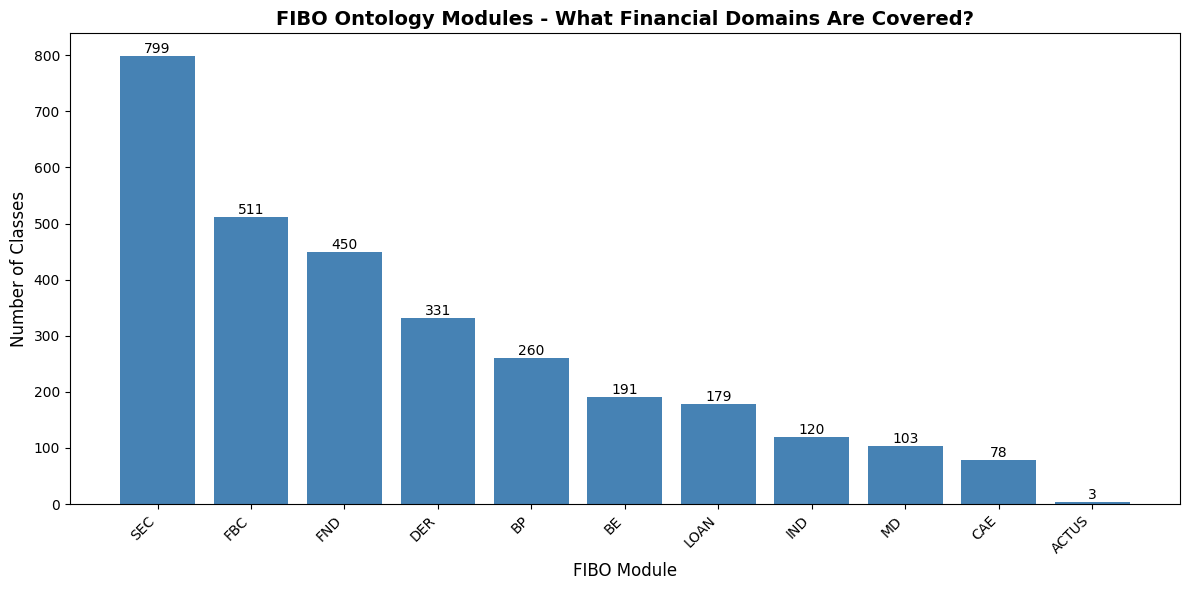


Module Descriptions (from FIBO metadata):
  SEC    (799 classes): Contains concepts like: auto asset-backed security, consumer asset-backed security, credit card asset-backed security
  FBC    (511 classes): Contains concepts like: cross default provision, distressed ratings downgrade, failure to pay interest
  FND    (450 classes): Contains concepts like: capital surplus, earnings before interest, taxes, depreciation and amortization, currency basket
  DER    (331 classes): Contains concepts like: asset-backed credit default swap, basket credit default swap, contingent credit default swap
  BP     (260 classes): Contains concepts like: clearing, financial markets regulation, market data provision
  BE     (191 classes): Contains concepts like: family office, executive branch, judiciary
  LOAN   (179 classes): Contains concepts like: credit risk assessment, loan application at agreement stage, loan application at disbursement stage
  IND    (120 classes): Contains concepts like: avera

In [18]:
# Show actual FIBO module structure - what domains does it cover?
print("=== FIBO Module Structure ===\n")

query = """
PREFIX owl: <http://www.w3.org/2002/07/owl#>
SELECT ?module (COUNT(DISTINCT ?class) as ?classcount) WHERE {
    ?class a owl:Class .
    FILTER(CONTAINS(STR(?class), "fibo/ontology/"))
    BIND(REPLACE(STR(?class), ".*fibo/ontology/([^/]+)/.*", "$1") as ?module)
}
GROUP BY ?module
ORDER BY DESC(?classcount)
"""

results = list(g.query(query))
modules = {}
for row in results:
    if row.module:  # Filter out empty modules
        modules[str(row.module)] = int(row.classcount)

# Create bar chart of FIBO modules
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sorted_modules = sorted(modules.items(), key=lambda x: x[1], reverse=True)[:15]
module_names = [m[0] for m in sorted_modules]
module_counts = [m[1] for m in sorted_modules]

bars = plt.bar(module_names, module_counts, color='steelblue')
plt.xlabel('FIBO Module', fontsize=12)
plt.ylabel('Number of Classes', fontsize=12)
plt.title('FIBO Ontology Modules - What Financial Domains Are Covered?', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Get actual module descriptions from FIBO metadata
print("\nModule Descriptions (from FIBO metadata):")

# Query for module-level ontology descriptions
query_module_desc = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX sm: <http://www.omg.org/techprocess/ab/SpecificationMetadata/>

SELECT DISTINCT ?module ?title ?abstract WHERE {
    ?ontology a owl:Ontology .
    FILTER(CONTAINS(STR(?ontology), "fibo/ontology/"))
    BIND(REPLACE(STR(?ontology), ".*fibo/ontology/([^/]+)/.*", "$1") as ?module)
    OPTIONAL { ?ontology dct:title ?title }
    OPTIONAL { ?ontology dct:abstract ?abstract }
    OPTIONAL { ?ontology sm:moduleName ?modName }
}
"""

module_info = {}
for row in g.query(query_module_desc):
    if row.module and row.module not in module_info:
        module_info[str(row.module)] = {
            'title': str(row.title) if row.title else None,
            'abstract': str(row.abstract) if row.abstract else None
        }

# If no metadata, sample actual content from each module
for module, class_count in sorted_modules[:8]:
    if module in module_info and module_info[module]['title']:
        print(f"  {module:6} ({class_count:3} classes): {module_info[module]['title']}")
    else:
        # Get sample classes from this module to understand its content
        sample_query = """
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        SELECT DISTINCT ?label WHERE {
            ?class a owl:Class .
            ?class rdfs:label ?label .
            FILTER(CONTAINS(STR(?class), "fibo/ontology/""" + module + """/"))
        } LIMIT 5
        """
        samples = [str(r.label) for r in g.query(sample_query)]
        if samples:
            print(f"  {module:6} ({class_count:3} classes): Contains concepts like: {', '.join(samples[:3])}")
        else:
            print(f"  {module:6} ({class_count:3} classes)")


In [19]:
# Show an actual financial concept hierarchy - how FIBO models corporations
print("\n=== How FIBO Models a Corporation (Hierarchy) ===\n")

query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>

SELECT ?class ?label WHERE {
    # Find Corporation class
    ?corp rdfs:label "corporation"@en .
    
    # Get all its superclasses (what it inherits from)
    ?corp rdfs:subClassOf* ?class .
    ?class rdfs:label ?label .
    FILTER(LANG(?label) = "en" || LANG(?label) = "")
}
"""

results = list(g.query(query))
if results:
    print("Corporation inherits from (bottom to top):")
    for i, row in enumerate(results[:10]):
        indent = "  " * min(i, 5)
        print(f"{indent}↳ {row.label}")
else:
    # Try alternative search
    query = """
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    SELECT DISTINCT ?class ?label WHERE {
        ?class rdfs:label ?label .
        FILTER(CONTAINS(LCASE(STR(?label)), "business") || 
               CONTAINS(LCASE(STR(?label)), "organization") ||
               CONTAINS(LCASE(STR(?label)), "entity"))
        FILTER(CONTAINS(STR(?class), "fibo"))
    } LIMIT 10
    """
    results = list(g.query(query))
    print("Key business entity concepts in FIBO:")
    for row in results:
        print(f"  • {row.label}")

print("\n" + "="*60)

# Show what properties a financial instrument has
print("\n=== What Makes a Financial Instrument in FIBO? ===\n")

query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>

SELECT DISTINCT ?property ?label WHERE {
    ?instrument rdfs:label ?instLabel .
    FILTER(CONTAINS(LCASE(STR(?instLabel)), "instrument"))
    FILTER(CONTAINS(STR(?instrument), "fibo"))
    
    ?property rdfs:domain ?instrument .
    ?property rdfs:label ?label .
} LIMIT 20
"""

results = list(g.query(query))
if results:
    print("Financial instruments have these properties:")
    for row in results:
        print(f"  • {row.label}")
else:
    # Show properties that mention financial terms
    query = """
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    SELECT DISTINCT ?prop ?label WHERE {
        ?prop rdfs:label ?label .
        FILTER(CONTAINS(LCASE(STR(?label)), "issue") || 
               CONTAINS(LCASE(STR(?label)), "maturity") ||
               CONTAINS(LCASE(STR(?label)), "price"))
        FILTER(CONTAINS(STR(?prop), "fibo"))
    } LIMIT 15
    """
    results = list(g.query(query))
    print("Key financial properties in FIBO:")
    for row in results:
        print(f"  • {row.label}")



=== How FIBO Models a Corporation (Hierarchy) ===

Corporation inherits from (bottom to top):
↳ corporation


=== What Makes a Financial Instrument in FIBO? ===

Financial instruments have these properties:
  • has primary holder
  • identifier issued by
  • cashflow precedence
  • provides credit support to
  • has tick value
  • has settlement terms
  • has valuation terms
  • has exercise terms
  • has rate of return
  • is linked to fallback
  • has financial instrument short name
  • is negotiable
  • is denominated in
  • is legally recorded in
  • is compounded
  • price quoted ex dividend
  • calculation following
  • has outlook period
  • denomination
  • simulates
